In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact


In [2]:
# define the model # seed 4
np.random.seed(4)#(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = 7

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

#evaluating J for BAS dataset
#J=-1*wt#np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])
# defining h
#h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
#h=np.zeros(np.shape(J)[0])
# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')
#model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {np.shape(J)[0]}")

In [3]:
# set beta
beta = 1.0#1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

     MODEL : my_model |  beta : 1.0
Num Most Probable States : 8
Entropy : 2.4519802748957393
---------------------------------------------


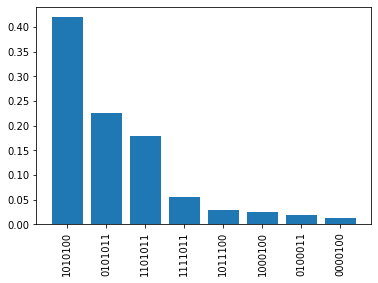

In [4]:
## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary()

In [5]:
steps = 5000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

In [6]:
### H_mix
from qumcmc.quantum_mcmc_routines_qulacs_exact import create_X_mixer_hamiltonian

In [7]:
H_mixer=create_X_mixer_hamiltonian(num_spins=n_spins,
                                    weight_individual_pauli=1)

type_mixer_hamiltonian: <class 'qulacs_core.Observable'>
list_individual_terms:
['X 0 ', 'X 1 ', 'X 2 ', 'X 3 ', 'X 4 ', 'X 5 ', 'X 6 ']


In [8]:
# aa=H_mixer.get_matrix()
# print(type(aa))
# aa.toarray()

In [ ]:
# Run quantum mcmc: exact time evolution
steps=5000
qamcmc_chain_1=quantum_mcmc_exact(n_hops=steps,
                                model=model,
                                H_mix=H_mixer,
                                temperature=1/beta,
                                verbose= True)
# took ~10 minutes for num_spins=7 and 5K iterations.

In [10]:
cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)
qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)

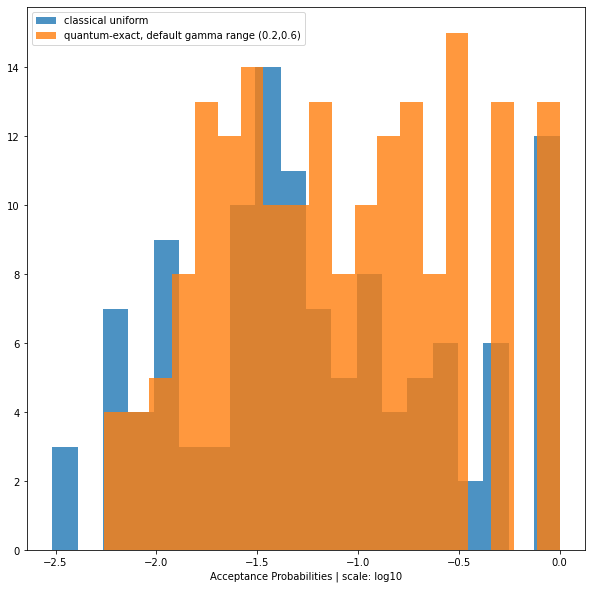

In [11]:
# acceptance prob
plt.figure(figsize=(10,10))

plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
plt.hist(np.log10(qumcm1_statistic['acceptance_prob']),label= 'quantum-exact, default gamma range (0.2,0.6)' , alpha= 0.8, bins= 20)

# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

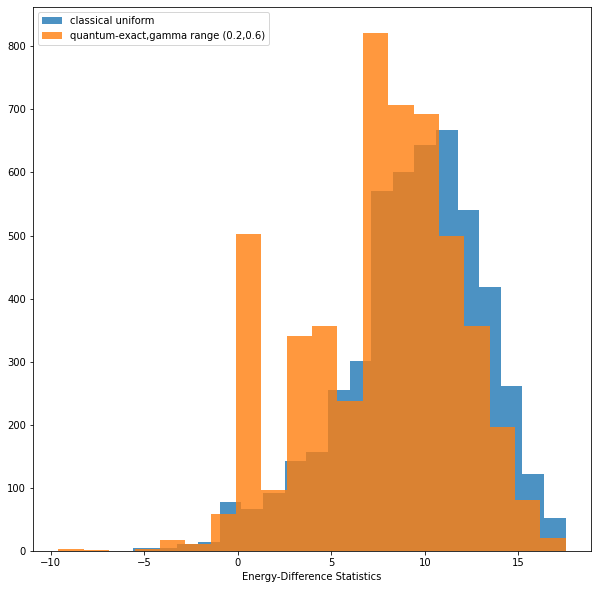

In [12]:
# energy-difference
plt.figure(figsize=(10,10))

plt.hist(cl_statistic['energy'],label= 'classical uniform' ,alpha= 0.8, bins= 20)
plt.hist(qumcm1_statistic['energy'],label= 'quantum-exact,gamma range (0.2,0.6)' , alpha= 0.8, bins= 20)
# plt.xscale("log")

plt.xlabel("Energy-Difference Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

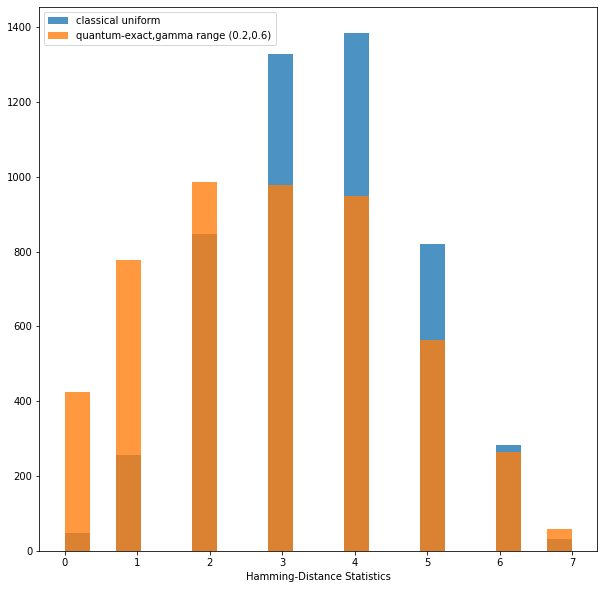

In [13]:
# hamming distance
plt.figure(figsize=(10,10))

plt.hist(cl_statistic['hamming'],label= 'classical uniform' ,alpha= 0.8, bins= 20)
plt.hist(qumcm1_statistic['hamming'],label= 'quantum-exact,gamma range (0.2,0.6)' , alpha= 0.8, bins= 20)
# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

In [17]:
# magnetisation
magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cl_chain)
magnetization_q1 = calculate_runnning_magnetisation(qamcmc_chain_1)

100%|██████████| 5000/5000 [00:02<00:00, 1812.13it/s]


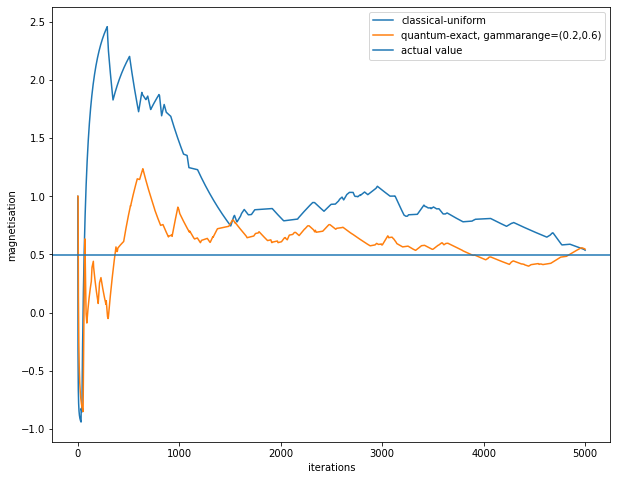

In [18]:
plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical-uniform')
plt.plot(magnetization_q1, label= 'quantum-exact, gammarange=(0.2,0.6)')
plt.axhline(magnetization_model, label= 'actual value')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

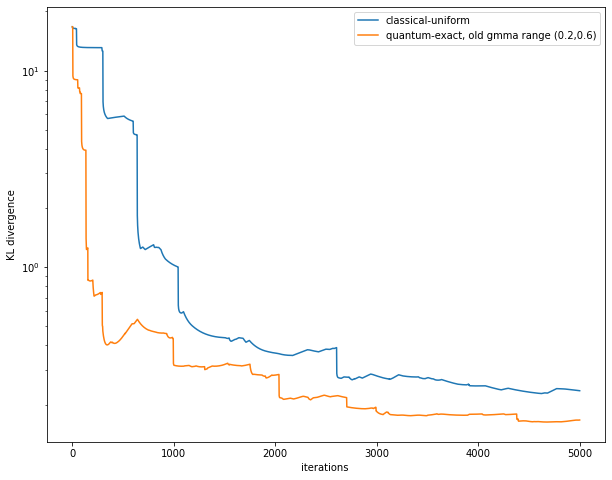

In [15]:
# KL divergence
kldiv_c = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, cl_chain)
kldiv_q1 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_1)

plt.figure(figsize=(10,8))
plt.plot(kldiv_c, label= 'classical-uniform')
plt.plot(kldiv_q1, label= 'quantum-exact, old gmma range (0.2,0.6)')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()